# Автоматическое определение языка текста

In [1]:
import argparse
import codecs
import unicodedata
import operator

import nltk
import numpy

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

%matplotlib inline

/Users/Alexander/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Будем решать задачу определения языка печатного текста. В файле `europarl.test.txt` содержатся записи депатов в Европарламенте. Каждая строка содержит код языка и высказывание на этом языке, например, на болгарском:

`bg	(DE) Г-н председател, след повече от 300 години колониално управление и след като континентът се превърна в арена на Студената война, днес Латинска Америка вече е един от нововъзникващите региони в света.`

Код языка будет целевой переменной, а из высказывания нам предстоит извлечь признаки.

Один из возможных подходов состоит в том, чтобы в качестве признаков использовать тройки из подряд идущих символов, встречающихся в словах. Предположение состоит в том, что для каждого языка список наиболее популярных троек более-менее уникален. Попробуем проверить это предположение.

Комм.: в данном случае: документ — высказывание

## Считывание данных

In [2]:
DS_PATH = "./europarl.test.txt" # Path to the data file
N_GRAM = 3 # Extract symbol sequences of length N
TOP_TOKENS = 10 # Number of top selected n-grams for each language

In [3]:
def read_documents(data_path):
    """
    Reads a sequence of documents from the text file
    located on a given path.

    Returns:
        A generator of tuples (LANG_CODE, unicode)
    """
    with codecs.open(data_path, 'rU', "utf-8") as data_file:
        for line in data_file:
            lang, doc = line.strip().split('\t')
            yield lang, doc

In [4]:
def normalise_document(doc):
    """
    Convert document to lower-case and remove accents
    
    Returns:
        A normalised document as unicode
    """
    return ''.join(c for c in unicodedata.normalize('NFD', doc.lower()) if not unicodedata.combining(c))

In [5]:
def tokenize_document(doc, n):
    """
    Split document in N-Grams
    
    TODO: implement this

    Returns:
        Iterable (generator or list) of unicode n-grams
    """
    tokenizer = nltk.WordPunctTokenizer()
    for token in tokenizer.tokenize(doc):
        if len(token) >= n:
            for ngram in nltk.ngrams(token, n):
                yield u"".join(ngram)

list(tokenize_document('kweqlwurg we ewroiwehriweq lapw', 3))

[u'kwe',
 u'weq',
 u'eql',
 u'qlw',
 u'lwu',
 u'wur',
 u'urg',
 u'ewr',
 u'wro',
 u'roi',
 u'oiw',
 u'iwe',
 u'weh',
 u'ehr',
 u'hri',
 u'riw',
 u'iwe',
 u'weq',
 u'lap',
 u'apw']

Первым делом нам необходимо зачитать данные из файла. Будем читать 3 структуры данных:

- docs - список словарей, каждый из которых соответствует одному документу и содержит количество вхождений для каждой n-граммы (токена)
- langs - список, содержащий классы докуметов (каждому коду языка соответствует числовой класс)
- lang_freq - словарь, который нужен для подсчета ниболее популярных n-грам для каждого языка. Элементы этого словаря: код языка -> (id класса, частоты n-грам (аналогично docs)) 

Для того, чтобы заработал код, зачитывающий данные, необходимо (до) реализовать функции, перечисленные выше.

In [6]:
# A list of dicts, each representing one document in format:
# {token: count1, ...}
docs = []
# Language code for each dict (0-based)
langs = []
# A list of tuples, each tuple corresponds to one language
# First compunent is the code of the language, second is its token frequencies
# Contains entries like {lang_code: (lang_id, {token_frequencies})}
lang_freq = {}

for lang, doc in read_documents(DS_PATH):
    normalized_doc = normalise_document(doc)

    token_freq = {}
    for token in tokenize_document(normalized_doc, N_GRAM):
        token_freq[token] = 1 + token_freq.get(token, 0)
        if lang not in lang_freq:
            print("Found language %s: %d" % (lang, len(lang_freq)))
            lang_freq[lang] = (len(lang_freq), {})
        lang_freq[lang][1][token] = 1 + lang_freq[lang][1].get(token, 0)

    docs.append(token_freq)
    langs.append(lang_freq[lang][0])

Found language bg: 0
Found language cs: 1
Found language da: 2
Found language de: 3
Found language el: 4
Found language en: 5
Found language es: 6
Found language et: 7
Found language fi: 8
Found language fr: 9
Found language hu: 10
Found language it: 11
Found language lt: 12
Found language lv: 13
Found language nl: 14
Found language pl: 15
Found language pt: 16
Found language ro: 17
Found language sk: 18
Found language sl: 19
Found language sv: 20


In [7]:
for k, v in docs[0].iteritems():
    print u'{} {}'.format(k, v)

ира 1
кон 1
рат 1
ара 1
кур 1
тар 1
тен 1
нов 1
уре 1
иза 1
ста 1
арт 1
ват 1
тир 1
рти 1
вро 1
202 1
евр 1
роп 1
рен 1
ато 1
при 1
ати 1
тиз 1
мар 1
бва 1
020 1
тон 1
аци 1
рив 1
изх 1
зхо 1
тря 1
ряб 1
ход 1
ябв 1
нку 1
нте 1
ент 1
онк 1
ция 1
зац 1
опа 1
ива 1


In [8]:
for k, v in lang_freq['bg'][1].iteritems():
    print k, v

рне 11
бли 38
рна 30
бло 3
опъ 17
рно 74
бла 53
опр 33
sco 1
бле 50
опу 7
nwe 1
фек 19
щое 1
фев 3
фед 1
псв 2
мии 1
aud 1
лаб 5
пса 8
мюс 2
пок 28
пол 185
пои 4
иня 8
поо 6
поп 8
пом 75
пон 22
пов 50
пог 8
пож 25
поз 39
под 215
пое 7
гъл 3
пош 1
пощ 1
поя 1
гън 1
пот 41
рни 39
пор 111
пос 136
поч 19
пох 2
мюн 1
лаи 3
опт 1
вож 1
мво 1
лак 1
тфо 2
тюн 1
фер 11
фес 4
щот 36
лан 53
блъ 2
опо 14
опи 22
блю 13
опл 9
опе 223
рня 1
опа 103
днъ 5
тле 2
инн 6
lvi 1
тло 1
тли 11
лат 38
зих 1
зиц 16
зич 2
зир 20
зис 39
зит 6
мня 7
анч 1
рьо 1
зия 9
щож 1
сюл 2
наз 10
над 42
нае 18
нав 27
наг 14
наб 22
нао 1
нап 83
нам 43
нан 61
нак 26
нал 83
наи 74
цял 23
смя 12
аши 28
смъ 2
ашн 10
лащ 7
ашв 1
аша 18
ner 1
nes 1
аше 20
sli 1
сми 10
ашт 3
сме 57
mei 1
сма 1
нац 26
нач 90
наф 1
нах 9
нат 215
нау 13
нар 48
нас 124
ная 7
инг 5
107 1
наш 46
мни 7
зие 3
зиз 1
мно 81
зиг 3
мна 4
зин 8
зио 2
зии 1
мне 12
зик 8
зил 4
яза 3
язв 8
езк 1
ези 80
езп 3
езо 34
езн 6
вчи 2
езв 3
еза 27
гля 1
езе 13
езд 3
свр 1


хен 2
хем 3
оук 2
оун 1
оуп 4
sen 1
хез 2
пля 1
еря 2
жик 1
ябъ 1
фат 2
бра 47
нои 4
фаг 1
ift 2
ван 342
фан 1
фал 5
фак 29
7х3 1
оша 2
acc 2
пла 46
пле 10
ack 1
пли 2
хер 1
пло 3
бха 4
бхв 5
иря 10
ноб 1
зсл 18
зтъ 2
бхо 39
шве 8
cме 1
шва 12
рвя 1
овл 4
овк 6
ови 108
ово 166
овн 55
рящ 4
ова 389
рят 12
ове 159
овд 5
бив 9
жед 3
биз 3
бид 1
бик 5
бил 43
жем 26
жен 139
био 3
жел 22
бим 2
бин 3
бит 34
бир 35
биц 5
бич 2
жер 9
бих 37
бия 2
овъ 3
рям 9
рян 2
овя 21
ову 1
овт 4
овс 8
ряв 31
овц 1
ряб 138
рве 6
рлс 1
нно 45
рва 13
съж 26
рвн 2
lde 2
рво 16
рви 17
рар 1
ник 35
oth 1
рст 16
нии 2
ещя 1
рся 2
миз 2
каш 1
чаи 25
uit 1
чак 14
чал 15
кас 7
кар 21
мин 43
кат 228
ках 3
мик 21
чав 50
кац 11
гва 4
цет 2
рзи 1
цер 1
цес 20
мер 77
вто 31
цед 9
цев 1
вти 3
цем 1
цен 50
цел 59
цеи 1
вта 2
ohn 1
мич 49
миц 15
мих 2
чая 4
кан 36
кам 48
мис 161
мир 28
каб 1
кав 7
чар 2
час 41
каз 72
каж 32
ссе 1
еща 27
еще 13
рсе 5
цру 1
рси 7
ещи 15
рск 11
ещн 1
рсо 2
ещо 16
all 1
sch 1
ali 1
ald 2
ale 2
г

жат 13
бещ 4
беш 57
bia 1
чил 6
жащ 2
рля 5
охо 2
ond 1
ъвт 1
ъвс 12
чре 16
охе 2
ъвъ 3
оха 3
лие 10
бях 25
цки 2
бят 2
бяс 5
ряд 3
nge 2
еве 15
ngl 1
егр 9
ряг 1
ngu 1
ъще 35
ибн 4
ибо 3
ъщо 67
ева 5
ъщн 15
ибе 7
ъщи 8
удс 1
995 1
ибъ 1
цка 1
ибр 2
ибс 1
лмс 1
999 1
янн 6
ври 6
уал 8
нни 36
вск 8
бяг 2
бяв 4
тящ 2
бял 1
ъвз 1
ици 119
ъве 73
ица 37
ъвм 8
зши 10
shm 1
охр 1
aen 1
пун 1
лъг 1
пуб 15
пув 1
нна 12
фия 2
оди 115
одл 5
одк 73
одн 46
взе 22
одп 13
одо 35
фич 3
ода 85
уан 2
иши 3
оде 20
одд 4
ишн 5
фир 3
лез 13
рия 50
хна 3
бат 18
рит 106
бар 11
рир 29
рич 33
хни 11
рих 3
щря 4
щен 10
щем 4
lug 1
олд 4
лоб 6
юци 17
ken 1
eul 1
щес 44
щна 1
щет 9
рил 41
рик 31
баи 2
рии 13
рип 2
рио 39
рин 43
рим 38
бав 16
рив 22
риб 14
риа 9
риз 62
риж 6
рие 66
рид 8
взр 1
дсе 91
фин 58
одъ 33
фик 28
одя 9
одс 12
одр 4
оду 24
jia 1
одх 23
одч 25
одц 1
пуш 1
пус 12
пут 1
екц 7
аук 1
неф 3
неч 1
нец 1
нес 51
нер 41
неу 3
нет 197
нея 5
цър 1
нещ 16
ещу 17
ауд 1
цъф 1
еуч 2
шка 5
еус 1
жци 1
шко 1

## Отбор признаков

Здесь предстоит выбрать топовые n-граммы для каждого языка (`select_features`) и отфильтровать документы так, чтобы в них остались только отобранные (`keep_only_features`)

In [9]:
from collections import Counter
def select_features(lang_freq, top_tokens):
    """
    From each language selects top_tokens to be used as features
    
    TODO: Implement this — DONE

    Returns:
        set(unicode tokens)
    """
    features = set()
    for lang, (lid, token_freq) in lang_freq.items():
        c = Counter(token_freq)
        top = c.most_common(top_tokens)
        features.update(t[0] for t in top)
    return features

print select_features({'bg':(0, {'a':2, 'b':1})}, 1)

set(['a'])


In [10]:
def keep_only_features(docs, features):
    """
    Removes non-feature tokens from the document representations
    """
    for token_freq in docs:
        for token in list(token_freq.keys()):
            if token not in features:
                del token_freq[token]

In [11]:
# Select top n features for each lang
features = select_features(lang_freq, TOP_TOKENS)
# Remove from documents all features except the selected
keep_only_features(docs, features)

# Transform documents to numpy matrix
dv = DictVectorizer()  # комм.: запомнить, классная вещь
# CountVectorizer еще круче. Начни уже носить с собой тетрадь!
x = dv.fit_transform(docs).todense()
y = numpy.array(langs)
print("Data set shape x=(%d x %d) y=%d" % (x.shape[0], x.shape[1], len(y)))

Data set shape x=(21000 x 151) y=21000


## Создание и настройка модели

В этом пункте требуется реализовать модель (NB) и оценить метрику `accuracy` на кросс-валидации.

In [12]:
from sklearn.base import BaseEstimator, ClusterMixin
import numpy as np


class MNB(BaseEstimator, ClusterMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        pass

    def fit(self, X, y=None):
        """
        Процедура обучения
        """
        
        ## Your Code Here
        # ...
        
        return self

    def predict_proba(self, X, y=None):
        """
        Процедура предсказания вероятности класса
        
        """
        return np.random.rand(X.shape[0], 1).reshape(-1, 1)
    
    def predict(self, X, y=None):
        """
        Процедура предсказания класса
        
        """
        return np.random.rand(X.shape[0], 1).reshape(-1, 1)
    

def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MNB()

In [18]:
from sklearn.model_selection import cross_val_score
# from sklearn.naive_bayes import MultinomialNB
def validate_model(model, x, y, folds=10):
    """
    Computes cross-validation score for the given data set and model.
    
    TODO: Implement this

    Returns:
        A numpy.array of accuracy scores.
    """
    
    return cross_val_score(model, x, y, cv=folds);

In [19]:
def plot_roc(model, x, y, class_ind=0):    
    # Compute ROC curve
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)
    fit = model.fit(x_train, y_train)
    y_prob = fit.predict_proba(x_test)   
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, class_ind], pos_label=class_ind)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class index %s' % class_ind)

_Замечание_ : обратите внимание, что тут нужно реализовать перебор параметров.

Model mean accuracy: 0.883904761905


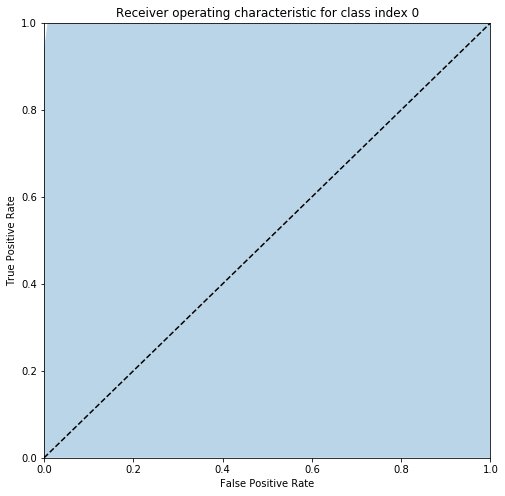

In [20]:
# TODO: Implement parameter grid search here
model = create_model()
# Print cross-validated accturacy
scores = validate_model(model, x, y)
print("Model mean accuracy: {}".format(numpy.mean(scores)))

# Plot ROC
plt.figure(figsize=(8, 8))
plot_roc(model, x, y, 0)
plt.show()

## Создание и настройка модели

В этом пункте требуется реализовать модель (NB) и перебрать различные значения параметров. Предлагается попробовать Multinumial и Bernoulli варианты из sklearn и несколько значений параметров (alpha, binarize, fit_prior) и выбрать наилучшую модель на основании метрики `accuracy`, полученной на кросс-валидации.

In [21]:
def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MultinomialNB()

Model mean accuracy: 0.883904761905


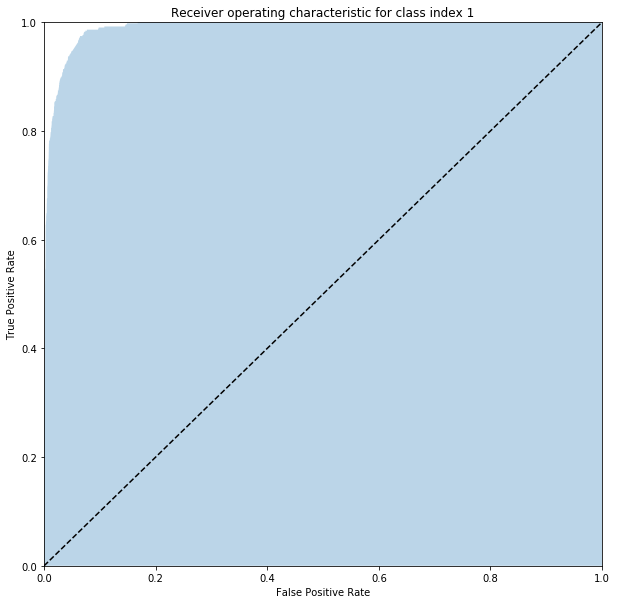

In [22]:
model = create_model()
# Print cross-validated accturacy
scores = validate_model(model, x, y)
print("Model mean accuracy: {}".format(numpy.mean(scores)))

# Plot ROC
plt.figure(figsize=(10, 10))
plot_roc(model, x, y, 1)
plt.show()

## Дополнительно

- Выясните, какие классы чаще всего путаются (на кросс-валидации!)
- Сравните NB и KNN